## **1. Data Analysis**

In this question we will explore how different ways of computing centrality leads us to different rankings of vertices if we wish to rank them by "importance."

We will be using the data available here: https://www.cise.ufl.edu/research/sparse/matrices/SNAP/p2p-Gnutella09.html

Please download the data (in .mat format) and load it into your solution using the provided code.

In [ ]:
# Data loading
import scipy
from scipy.io import loadmat
import numpy as np
import networkx as nx

# the actual scipy sparse array is stored inside an annoying data structure within the .mat file
# so I found the correct indices to extract it for you
A = loadmat("p2p-Gnutella09.mat")["Problem"][0][0][2].tocoo()

# need to set diagonal to 1 so as to ensure each vertex has nonzero degree
A.setdiag(1)

# compute the degrees of each vertex
vertex_degrees = np.asarray(A.sum(axis=0)).reshape(-1)
print(type(A), A.shape)

# let us convert this graph into a networkx-friendly representation
G = nx.convert_matrix.from_scipy_sparse_matrix(A, create_using=nx.DiGraph)
print("num nodes: ", len(G.nodes()), "num edges:", len(G.edges()), "is_directed: ", nx.is_directed(G))

<class 'scipy.sparse.coo.coo_matrix'> (8114, 8114)
num nodes:  8114 num edges: 34127 is_directed:  True


### 2.1 Properties of the Gnutella09 Graph

Is this graph connected? How many connected components are in this graph? What is the degree distribution of the graph?

Graph is strongly connected :  False
Number of strongly connected components :  5491


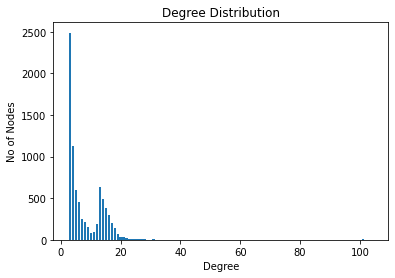

In [ ]:
import matplotlib.pyplot as plt 

print("Graph is strongly connected : ", nx.is_strongly_connected(G))
print("Number of strongly connected components : ", nx.number_strongly_connected_components(G))

degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
plt.bar(*np.unique(degree_sequence, return_counts=True))
plt.title("Degree Distribution")
plt.xlabel("Degree")
plt.ylabel("No of Nodes")
plt.show()

### 2.2 Closeness Centrality 

Use the networkx package to compute the closeness centrality of the Gnutella09 graph. Rank the vertices by centrality (i.e. by plotting the degree of each on the x axis in sorted order and the centrality score on the y axis). What patterns do you see?

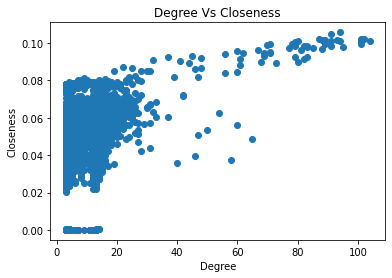

In [ ]:
# Compute closeness centrality
closeness = nx.closeness_centrality(G)

# Compute degrees
degrees_dict = dict(G.degree)

# Plot
plt.scatter(list(degrees_dict.values()), list(closeness.values()))
plt.title("Degree Vs Closeness")
plt.xlabel("Degree")
plt.ylabel("Closeness")
plt.show()

A linear correlation can be observed between closeness centrality and degree which becomes clearer as the degree increases. For nodes with smaller degrees (between 0 and 20), quite a lot of variability can be observed in the closeness centrality (from 0.00 to 0.08). 

### 2.3 Betweenness Centrality 

Use the networkx package to compute the betweenness centrality of the Gnutella09 graph. Rank the vertices by centrality exactly in the last part. What patterns do you see?

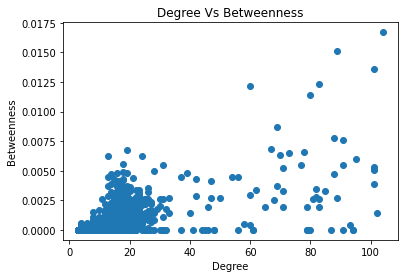

In [ ]:
# Compute betweenness centrality
betweenness = nx.betweenness_centrality(G, seed = 4)

# Plot
plt.scatter(list(degrees_dict.values()), list(betweenness.values()))
plt.title("Degree Vs Betweenness")
plt.xlabel("Degree")
plt.ylabel("Betweenness")
plt.show()

There doesn't seem to be any strong correlation between betweenness centrality and degree. 

### 2.4 Eigenvector Centrality 

Use the networkx package to compute the eigenvector centrality of the Gnutella09 graph. Rank the vertices by centrality exactly like the past two parts. What patterns do you see?

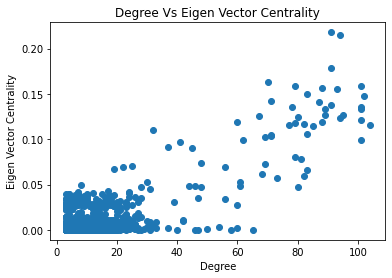

In [ ]:
# Compute eigen vector centrality
eigenvector_centrality = nx.eigenvector_centrality(G)

# Plot
plt.scatter(list(degrees_dict.values()), list(eigenvector_centrality.values()))
plt.title("Degree Vs Eigen Vector Centrality")
plt.xlabel("Degree")
plt.ylabel("Eigen Vector Centrality")
plt.show()

Here too, a weak linear correlation can be observed between eigen vector centrality and degree.

### 2.5 Pagerank Centrality 

We would like to compute the Pagerank of each vertex and use those scores as rankings. I have provided a quick Pagerank algorithm for you. Please use it to compute the Pagerank scores of each vertex (using $\alpha=0.2,0.4,0.6,0.8$) and rank the vertices like the last three parts. What patterns do you see?

**Reminder**: be sure to convert the graph into a Markov Chain (i.e. $l_1$ normalize the rows) **before** using the pagerank function! You might also find it handy to know that you can convert numpy $\texttt{matrix}$ datatype to numpy $\texttt{array}$ datatype using the function $\texttt{np.asarray}$()

In [ ]:
def smart_pagerank(P: np.ndarray, alpha: float,
                   epsilon: float=1e-9, max_iters=1e6) -> np.ndarray:
    N: int = P.shape[0]
    delta: float = np.inf

    v: np.ndarray = np.full((1,N), 1.0/N)
    q_t: np.ndarray = np.full((1,N), 1.0/N)
    num_iter: int = 0

    while delta >= epsilon and num_iter < max_iters:
        q_t_plus_1: np.ndarray = alpha*P.T.dot(q_t.T).T # alpha*x*P but plays better
                                                        # with scipy <-> numpy apis
        beta: float = np.sum(q_t) - np.sum(q_t_plus_1)
        q_t_plus_1 += beta*v

        delta = np.linalg.norm(q_t_plus_1-q_t, 2)
        q_t = q_t_plus_1
        num_iter += 1

    return q_t

In [ ]:
from sklearn.preprocessing import normalize
import scipy

adjacency_matrix = nx.adjacency_matrix(G)
transition_matrix = normalize(adjacency_matrix, axis=1, norm='l1')
transition_matrix = scipy.sparse.csr_matrix.toarray(transition_matrix)

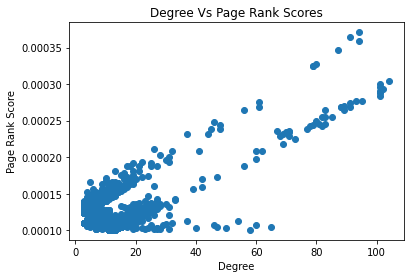

In [ ]:
# Compute Page Rank Scores
page_rank_scores = smart_pagerank(P = transition_matrix, alpha = 0.2)

# Plot
plt.scatter(list(degrees_dict.values()), page_rank_scores)
plt.title("Degree Vs Page Rank Scores")
plt.xlabel("Degree")
plt.ylabel("Page Rank Score")
plt.show()

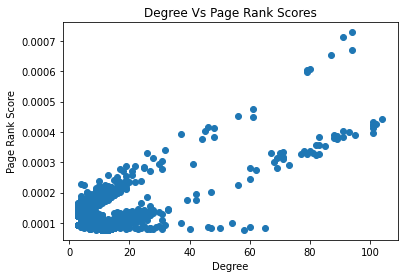

In [ ]:
# Compute Page Rank Scores
page_rank_scores = smart_pagerank(P = transition_matrix, alpha = 0.4)

# Plot
plt.scatter(list(degrees_dict.values()), page_rank_scores)
plt.title("Degree Vs Page Rank Scores")
plt.xlabel("Degree")
plt.ylabel("Page Rank Score")
plt.show()

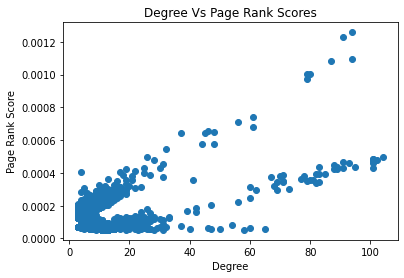

In [ ]:
# Compute Page Rank Scores
page_rank_scores = smart_pagerank(P = transition_matrix, alpha = 0.6)

# Plot
plt.scatter(list(degrees_dict.values()), page_rank_scores)
plt.title("Degree Vs Page Rank Scores")
plt.xlabel("Degree")
plt.ylabel("Page Rank Score")
plt.show()

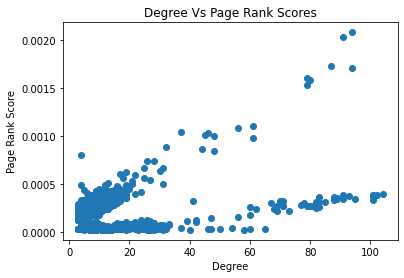

In [ ]:
# Compute Page Rank Scores
page_rank_scores = smart_pagerank(P = transition_matrix, alpha = 0.8)

# Plot
plt.scatter(list(degrees_dict.values()), page_rank_scores)
plt.title("Degree Vs Page Rank Scores")
plt.xlabel("Degree")
plt.ylabel("Page Rank Score")
plt.show()

A linear correlation can be observed between degree and page rank which becomes weaker as alpha increases i.e. the pattern becomes more obscure. The range of the page rank scores increase as alpha increase. For the same degree, two sets of nodes seem to have different page rank scores.